In [1]:
import numpy as np
import pandas as pd
pd.set_option('precision', 10)

import scipy.sparse
import pickle
import xgboost as xgb

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 20,7

import mix as mix
import db_column_name as db

columnName = db.ColumnName()

def modify(df):
    df = df.drop(['min slptend', 'min advRh850', 'min rainc'], axis=1)
    df.set_index('actual_date', inplace=True)
    df = df[[x for x in df.columns if 'min' in x or x == columnName.value]]
    return mix.clean_dataset(df)
    
X_train = pd.read_csv('./date/X_train.csv')
X_train = modify(X_train)

X_test = pd.read_csv('./date/X_test.csv')
X_test = modify(X_test)

X_train, target_train = mix.getTarget(X_train)
X_test, target_test = mix.getTarget(X_test)

In [2]:
default_params = {
    'verbosity':3,
    'max_depth': 3,
#     # add random 
    'subsample': 0.7,
    'seed': 42,    
}
# num_rounds = 1500
# early_stopping_rounds=10

reg = xgb.XGBRegressor(**default_params)

reg.fit(X_train, target_train[[columnName.value]]) 

target_test['XGB prediction'] = reg.predict(X_test)
target_train['XGB prediction'] = reg.predict(X_train)

mix.print_mean(target_test, target_train, columnName.value, 'XGB prediction')

Mean squared error on train 4.084287264461789 and test 13.979750428514427
Mean absolute error on train 1.5349522093855636 and test 2.806509663895065


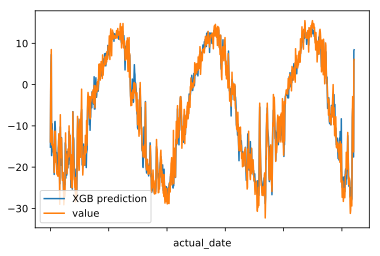

In [3]:
target_train[['XGB prediction', columnName.value]].plot()

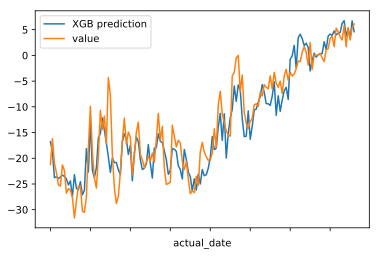

In [4]:
target_test[['XGB prediction', columnName.value]].plot()

In [5]:
# fig, ax = plt.subplots(figsize=(20, 7))
# xgb.plot_importance(reg, ax=ax);

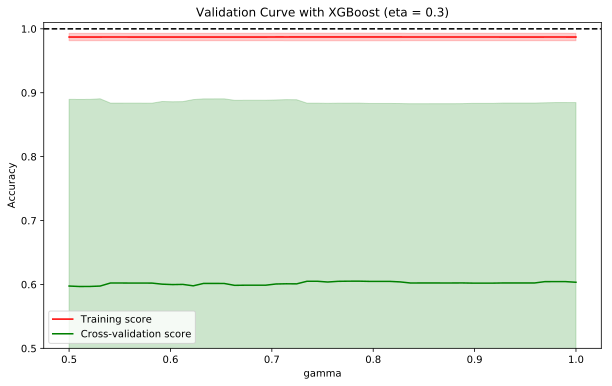

Best cross-validation result (0.61) obtained for 0.7857142857142857 gamma


In [6]:
# The proper way of choosing multiple hyperparameters of an estimator are 
# of course grid search or similar methods (see Tuning the hyper-parameters of an estimator)
# that select the hyperparameter with the maximum score on a validation set or multiple
# validation sets. Note that if we optimized the hyperparameters based on a validation score
# the validation score is biased and not a good estimate of the generalization any longer.
# To get a proper estimate of the generalization we have to compute the score on another test set.
# However, it is sometimes helpful to plot the influence of a single hyperparameter on
# the training score and the validation score to find out whether the estimator
# is overfitting or underfitting for some hyperparameter values.

from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

gamma_range = np.linspace(0.5, 1.0, num=50)

train_scores, test_scores = validation_curve(
    xgb.XGBRegressor(**default_params),
    X_train, target_train[[columnName.value]],
    param_name = 'gamma',
    param_range = gamma_range,
    cv=TimeSeriesSplit(n_splits=10))


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("gamma")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.01)

plt.plot(gamma_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(gamma_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(gamma_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(gamma_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} gamma".format(test_scores_mean[i], 
                                                                             gamma_range[i]))

# очень большое смещение
# разброс растет практически сразу же

In [7]:
# Посмотрим, как число деревьев влияет на качество модели.


# xgb_model = xgb.XGBRegressor()
# xgb_grid = GridSearchCV(xgb_model,
#                    {'max_depth': range(1, 8)}, verbose=1, cv=TimeSeriesSplit(n_splits=10))
# xgb_grid.fit(X_train, target_train[[columnName.value]])

# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)
# target_test['XGB Gride'] = xgb_grid.predict(X_test)
# target_train['XGB Gride'] = xgb_grid.predict(X_train)
# mix.print_mean(target_test, target_train, columnName.value, 'XGB Gride')

# target_test[['XGB Gride', columnName.value]].plot()

In [8]:

# target_train[['XGB Gride', columnName.value]].plot()